In [36]:
# Example performance of Degenhart stabilizer for ~2 weeks:

%load_ext autoreload
%autoreload 2

import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import glob
import sys

[sys.path.append(f) for f in glob.glob('utils/*')]
from preprocess import DataStruct
from firingrate import raster2FR
from plotting_utils import figSize
from lineplots import plotsd
from stabilizer_utils import *
from session_utils import *


from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import FactorAnalysis, PCA


files = glob.glob('D:/T5_ClosedLoop/*')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
# Fit PCA model to trajectories around goCue for radial-8 task:

f            = files[2]
task         = 'cursor'
model_type   = 'PCA'
n_components = 3
sigma        = 2

# ----------------------
session             = DataStruct(f, alignScreens = True)
data, _, targLocs   = getNeuralAndCursor(session, sigma = sigma, task = task, blocks = None)
unique, labels      = np.unique(targLocs, axis = 0, return_inverse= True)

# remove center-back trials:
data   = [data[i] for i in np.where(labels != 4)[0]]
labels = labels[labels != 4]

model, ll  = fit_TrialConcatenatedModel(model_type, {'n_components' : n_components}, data)
#print(conditions)

Text(0.5, 0.92, 'First 400 msec trial activity (26.8%)')

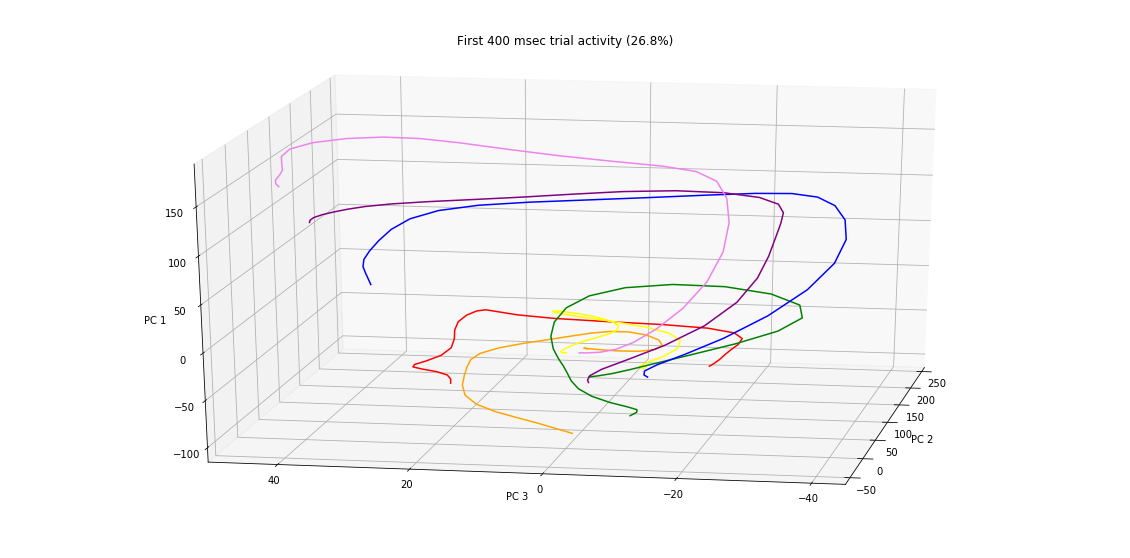

In [38]:
# Plot data from different reach directions: 

from mpl_toolkits.mplot3d import Axes3D 

figSize(10, 20)

endtrl_data       = [dat[:30, :] for dat in data]
avgd_data, _      = get_ConditionAveraged(endtrl_data, labels)
colors            = ['r', 'orange', 'yellow',  'green', 'k', 'blue', 'purple', 'violet']

fig = plt.figure()
ax  = fig.add_subplot(111, projection='3d')

for i, color in zip(np.arange(avgd_data.shape[2]), colors):
    if (unique[i] != [0, 0]).any():
        latent = model.transform(avgd_data[:, :, i])
        ax.plot(latent[:, 1], latent[:, 2], latent[:, 0], color = color)
        
angle = 190
ax.view_init(20, angle)
ax.set_xlabel('PC 2')
ax.set_ylabel('PC 3')
ax.set_zlabel('PC 1')
var_explained = np.round(100 * sum(model.explained_variance_ratio_), 1)
ax.set_title('First 400 msec trial activity (' + str(var_explained) + '%)')

## Subspace identification: hyperparameter sweep

In [39]:
# Fit both PCA and FA models to data, measure performance as function of latent dimensionality:

n_components       = np.arange(2, 21)

# train models for each dimensionality:
_, pca_models      = latentSweep('PCA', endtrl_data, sweep_dims = n_components)
_, fa_models       = latentSweep('FactorAnalysis', endtrl_data, sweep_dims =  n_components)

fa_models          = [get_FA_ExplainedVariance(fa) for fa in fa_models]  # calculate relative variance per component for FA models

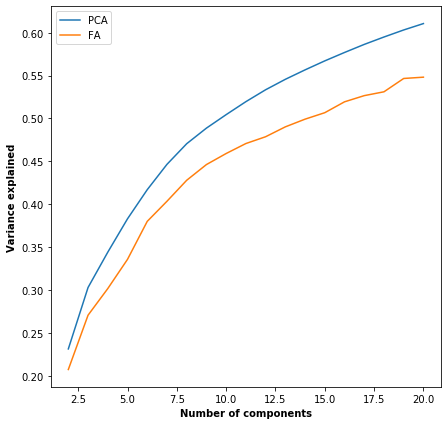

In [40]:
figSize(7, 7)
plt.plot(n_components, [sum(pca_models[i].explained_variance_ratio_) for i in range(len(pca_models))], label = 'PCA')
plt.plot(n_components, [sum(fa_models[i].explained_variance_ratio_) for i in range(len(pca_models))], label = 'FA')
plt.xlabel('Number of components', fontweight = 'bold')
plt.ylabel('Variance explained', fontweight = 'bold')
plt.legend()

### train linear regression on day 0, get baseline performance measure

- use latent space and full activity to estimate cursorErr signal

In [41]:
# general settings:
task                = None

# stabilizer settings:
sigma               = None
model_type          = 'FactorAnalysis'
n_components        = 12
toggle_ConditionAvg = False


#----------------------------

datas, targets, targLocs  = getNeuralAndCursor(session, sigma = sigma, task = task, blocks = None)
unique, labels            = np.unique(targLocs, axis = 0, return_inverse= True)

stab        = Stabilizer(model_type, n_components)
stab_data   =  [dat[:30, :] for dat in datas]
stab.fit_ref(stab_data, toggle_ConditionAvg, labels)


features_latent    = np.vstack([stab.ref_model.transform(dat) for dat in datas])
features_observed  = np.vstack(datas)
targets            = np.vstack(targets)

latent_decoder =  LinearRegression(fit_intercept = False, normalize = False)
full_decoder   =  LinearRegression(fit_intercept = False, normalize = False)

scores_latent   = cross_val_score(latent_decoder, features_latent - features_latent.mean(axis = 0), targets, cv = 10)
scores_observed = cross_val_score(full_decoder, features_observed - features_observed.mean(axis = 0), targets, cv = 10)

LinearRegression(fit_intercept=False)

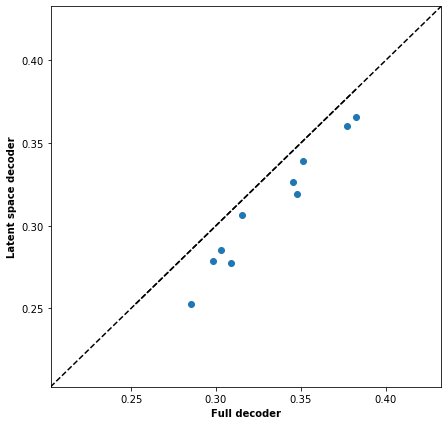

In [42]:
from lineplots import comparisonScatterPlot

figsize = 7

comparisonScatterPlot(scores_observed, scores_latent, figsize = figsize)

plt.ylabel('Latent space decoder', fontweight = 'bold')
plt.xlabel('Full decoder', fontweight = 'bold')

minval = np.min([np.min(scores_observed), np.min(scores_latent)]) - 0.05
maxval = np.max([np.max(scores_observed), np.max(scores_latent)]) + 0.05
plt.xlim([minval, maxval])
plt.ylim([minval, maxval])
plt.plot([minval, maxval], [minval, maxval], color = 'k', linestyle = '--')

full_decoder.fit(features_observed, targets)
latent_decoder.fit(features_latent, targets)

In [43]:
from copy import deepcopy
from scipy.linalg import orthogonal_procrustes

date   = list()
scores = np.zeros((4, 10)) # rows are 0 - no recalibration; 1 - mean recalibration; 2 - full recalibration; 3 - subspace stabilizer 
models = list()
Rs     = list()

for i in range(3, 13):
    file        = files[i]
    new_dat     = DataStruct(file, alignScreens = True)
    date.append(new_dat.date)
    
    train_x, test_x, train_y, test_y = getTrainTest(new_dat, train_frac = 0.5, sigma =  None, task = 'cursor', return_flattened = True)
    
    scores[0, i-3] = full_decoder.score(test_x - features_observed.mean(axis = 0), test_y)                  # no recalibration
    scores[1, i-3] = full_decoder.score(test_x - train_x.mean(axis = 0), test_y)                            # mean recalibration
    scores[2, i-3] = LinearRegression(normalize = False).fit(train_x, train_y).score(test_x, test_y)        # full recalibration

    stab.fit_new(train_x, B = 120, thresh = 0.05, conditionAveraged = False, conditions = None)
    
    newdata_latent = stab.transform(test_x)
    scores[3, i-3] = latent_decoder.score(newdata_latent, test_y)
    

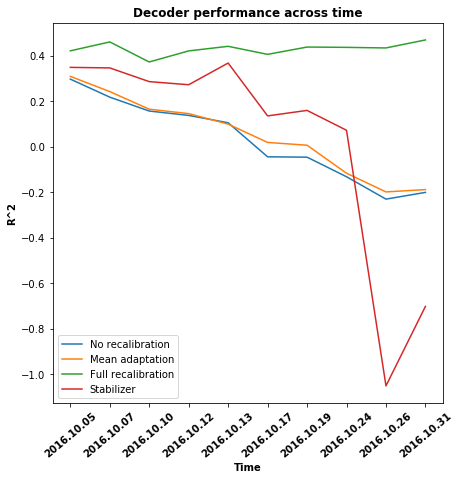

In [44]:
labels = ['No recalibration', 'Mean adaptation', 'Full recalibration',  'Stabilizer']

for i in range(4):
    plt.plot(scores[i, :].T, label = labels[i])
    
plt.xlabel('Time', fontweight = 'bold')
plt.ylabel('R^2', fontweight = 'bold')
plt.xticks(np.arange(len(date)), date, rotation = 40, fontweight = 'bold')
plt.title('Decoder performance across time', fontweight = 'bold')
plt.legend()